# 📊 F1 Data Analysis - Weighted Prediction Dataset
## Statistical analysis and feature exploration for circuit-specific F1 predictions

This notebook analyzes the weighted F1 prediction dataset to:
- Understand feature distributions and weighted data patterns
- Analyze target circuit history vs recent form data
- Explore prediction relevance categories (critical, high, medium, supplementary)
- Validate data quality for VAE/Bayesian Network training
- Examine circuit-specific patterns (street circuits, night races, etc.)
- Generate insights for optimal AI model architecture

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import glob
import os
from datetime import datetime

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("📊 Analysis libraries loaded")

📊 Analysis libraries loaded


## 📂 Load Latest Dataset

In [2]:
# Load the most recent weighted dataset
# Find the most recent weighted prediction data file
data_files = glob.glob('data/raw/*_prediction_weighted_*.csv')
if not data_files:
    print("❌ No weighted prediction data files found. Please run data collection first.")
    df = pd.DataFrame()
else:
    latest_file = max(data_files, key=os.path.getctime)
    circuit_name = os.path.basename(latest_file).split('_')[0].upper()
    print(f"🎯 Loading {circuit_name} GP weighted prediction data from: {latest_file}")
    
    df = pd.read_csv(latest_file)
    print(f"✅ Data loaded successfully: {df.shape}")
    print(f"📊 Standard F1 features: {[col for col in df.columns if col not in ['data_weight', 'data_source', 'prediction_relevance']]}")
    print(f"🎯 Weighting features: data_weight, data_source, prediction_relevance")
    
    # Display weight distribution
    if 'data_weight' in df.columns:
        print(f"\n⚖️ Weight Distribution:")
        weight_counts = df['data_weight'].value_counts().sort_index(ascending=False)
        for weight, count in weight_counts.items():
            relevance = df[df['data_weight'] == weight]['prediction_relevance'].iloc[0]
            print(f"   {weight:.1f} ({relevance:12}): {count:3d} records")

🎯 Loading SINGAPORE GP weighted prediction data from: data/raw\singapore_prediction_weighted_20251026_233906.csv
✅ Data loaded successfully: (240, 20)
📊 Standard F1 features: ['year', 'driver_name', 'driver_abbr', 'team', 'grid_pos', 'finish_pos', 'points', 'status', 'pos_change', 'quali_pos', 'q1_time', 'q2_time', 'q3_time', 'total_laps', 'tyres_used', 'pit_stops', 'gap_to_pole']
🎯 Weighting features: data_weight, data_source, prediction_relevance

⚖️ Weight Distribution:
   3.0 (critical    ):  60 records
   2.5 (high        ): 100 records
   1.5 (medium      ):  40 records
   1.2 (supplementary):  40 records


## 🔍 Dataset Overview

In [3]:
if not df.empty:
    print("📊 DATASET OVERVIEW")
    print("=" * 50)
    
    # Basic info
    print(f"Shape: {df.shape}")
    print(f"Years covered: {sorted(df['year'].unique())}")
    print(f"Unique drivers: {df['driver_name'].nunique()}")
    print(f"Unique teams: {df['team'].nunique()}")
    print(f"Total races represented: {len(df.groupby(['year', 'data_source']))}")
    
    # Weighted dataset specific info
    if 'data_weight' in df.columns:
        print(f"\n🎯 WEIGHTED DATASET FEATURES:")
        print(f"Weight range: {df['data_weight'].min():.1f} - {df['data_weight'].max():.1f}")
        print(f"Data sources: {df['data_source'].nunique()} unique sources")
        print(f"Prediction relevance levels: {df['prediction_relevance'].nunique()}")
        
        # Show data source breakdown
        print(f"\n📋 Data Source Breakdown:")
        source_summary = df.groupby('data_source').agg({
            'data_weight': 'first',
            'prediction_relevance': 'first',
            'driver_name': 'count'
        }).rename(columns={'driver_name': 'record_count'})
        source_summary = source_summary.sort_values('data_weight', ascending=False)
        
        for source, row in source_summary.head(10).iterrows():
            print(f"   {source[:30]:30} | Weight: {row['data_weight']:.1f} | {row['prediction_relevance']:12} | {row['record_count']:3d} records")
    
    print("\n📋 Column Information:")
    print(df.info())
    
    print("\n📈 Statistical Summary:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    display(df[numeric_cols].describe())

📊 DATASET OVERVIEW
Shape: (240, 20)
Years covered: [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Unique drivers: 30
Unique teams: 13
Total races represented: 12

🎯 WEIGHTED DATASET FEATURES:
Weight range: 1.2 - 3.0
Data sources: 12 unique sources
Prediction relevance levels: 4

📋 Data Source Breakdown:
   target_circuit_2024            | Weight: 3.0 | critical     |  20 records
   target_circuit_2022            | Weight: 3.0 | critical     |  20 records
   target_circuit_2023            | Weight: 3.0 | critical     |  20 records
   recent_form_belgium_2025       | Weight: 2.5 | high         |  20 records
   recent_form_hungary_2025       | Weight: 2.5 | high         |  20 records
   recent_form_netherlands_2025   | Weight: 2.5 | high         |  20 records
   recent_form_azerbaijan_2025    | Weight: 2.5 | high         |  20 records
   recent_form_great britain_2025 | Weight: 2.5 | high         |  20 records
   similar_circuit_azerbaijan_202 | Weight: 1.5 | medium     

,year,grid_pos,finish_pos,points,pos_change,quali_pos,q1_time,q2_time,q3_time,total_laps,pit_stops,gap_to_pole,data_weight
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,2024.500000,10.333333,10.416667,5.054167,-0.025000,10.500000,87.829133,63.705800,41.156442,55.562500,1.812500,-8.516275,2.241667
std,0.959428,5.790388,5.784966,7.193761,4.710822,5.778332,17.774148,41.655812,44.833686,16.784265,0.661438,13.445433,0.667799
min,2022.000000,0.000000,0.000000,0.000000,-16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-37.146000,1.200000
25%,2024.750000,5.000000,5.000000,0.000000,-2.000000,5.750000,72.420750,0.000000,0.000000,50.000000,2.000000,-13.735750,1.500000
50%,2025.000000,10.000000,10.000000,0.500000,0.000000,10.500000,91.163000,75.690500,0.000000,57.000000,2.000000,0.000000,2.500000
75%,2025.000000,15.000000,15.000000,8.500000,2.000000,15.250000,101.754000,92.283000,89.847500,69.000000,2.000000,0.402000,2.625000
max,2025.000000,20.000000,20.000000,25.000000,14.000000,20.000000,117.532000,115.518000,111.983000,78.000000,3.000000,6.106000,3.000000


## ⚖️ Weighted Data Analysis

⚖️ WEIGHTED DATA ANALYSIS


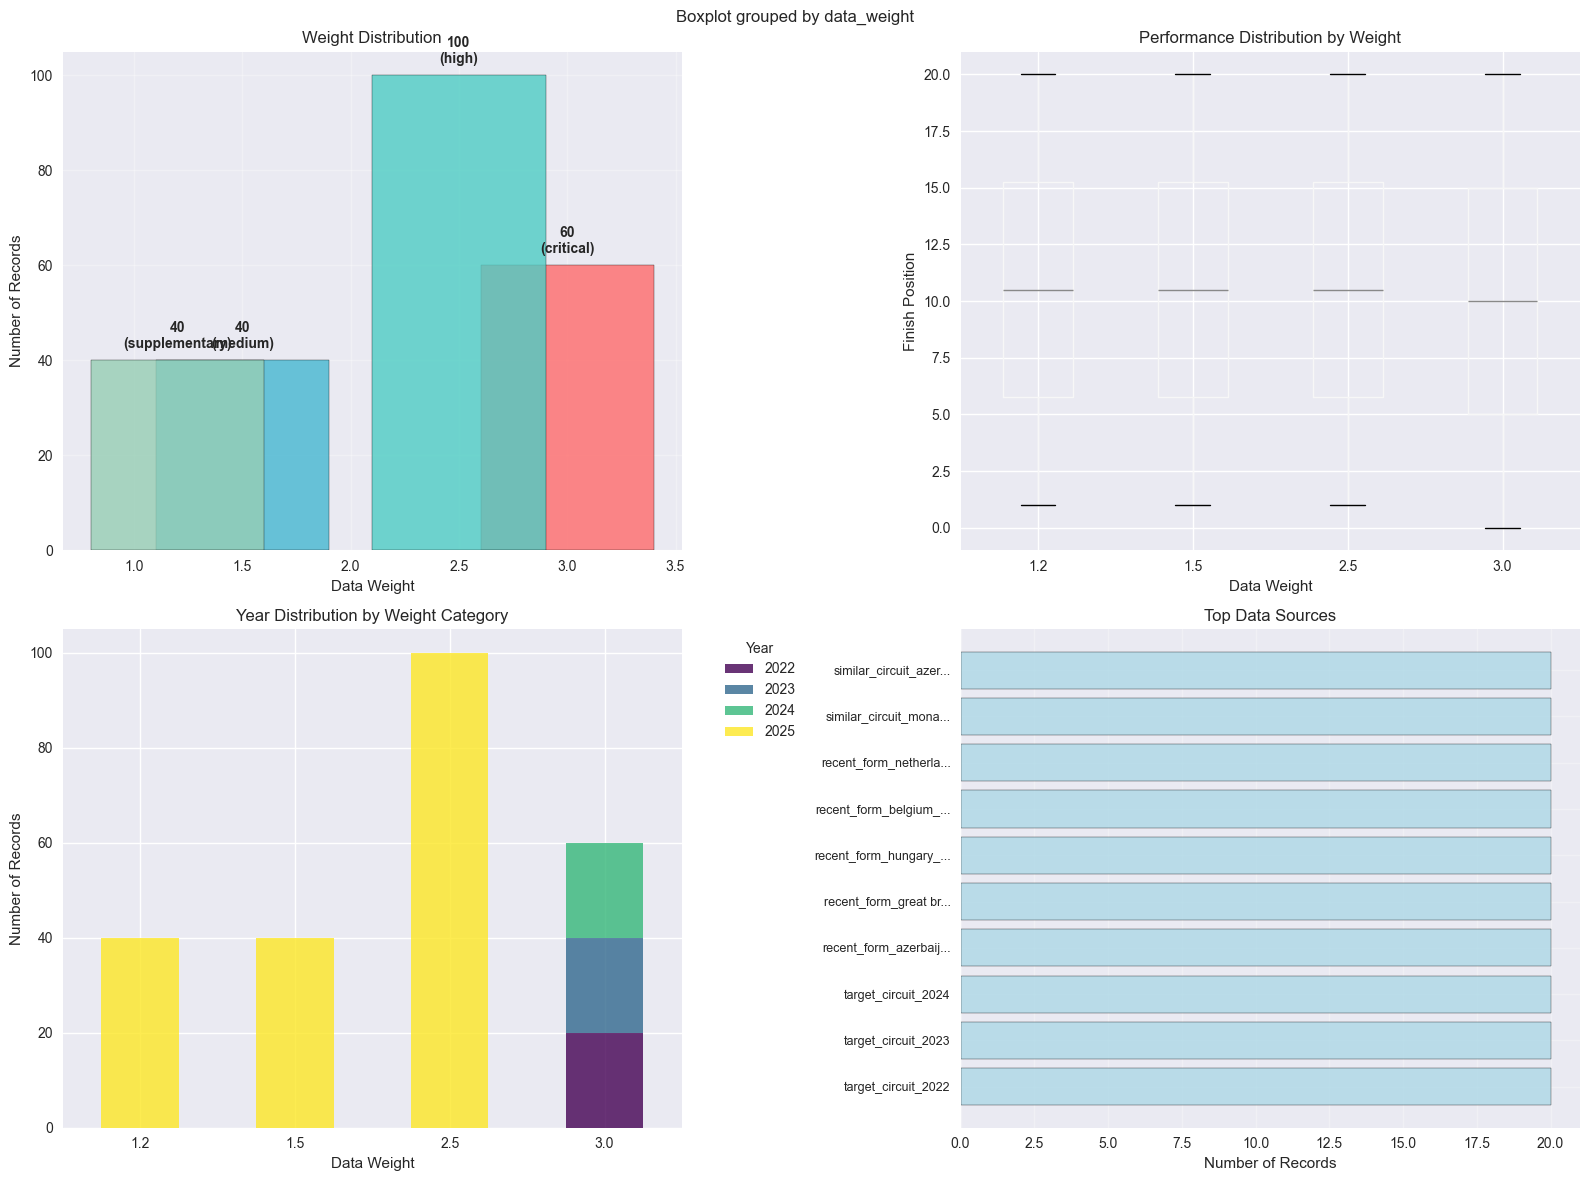


📈 WEIGHT EFFECTIVENESS:
             Avg_Finish  Finish_Std  Avg_Points  Avg_Pos_Change  Count
data_weight                                                           
1.2               10.50        5.84        5.05             0.0     40
1.5               10.50        5.84        5.05             0.0     40
2.5               10.50        5.80        5.05             0.0    100
3.0               10.17        5.83        5.07            -0.1     60

🎯 STRATEGIC INSIGHTS:
Weight 3.0 (critical    ): Avg finish 10.2 | Example: target_circuit_2022
Weight 2.5 (high        ): Avg finish 10.5 | Example: recent_form_azerbaijan_2025
Weight 1.5 (medium      ): Avg finish 10.5 | Example: similar_circuit_monaco_2025
Weight 1.2 (supplementary): Avg finish 10.5 | Example: night_race_bahrain_2025


In [4]:
if not df.empty and 'data_weight' in df.columns:
    print("⚖️ WEIGHTED DATA ANALYSIS")
    print("=" * 50)
    
    # Weight distribution analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('⚖️ Smart Weighting System Analysis', fontsize=16, fontweight='bold')
    
    # 1. Weight distribution
    weight_counts = df['data_weight'].value_counts().sort_index(ascending=False)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    axes[0,0].bar(weight_counts.index, weight_counts.values, 
                  color=colors[:len(weight_counts)], alpha=0.8, edgecolor='black')
    axes[0,0].set_xlabel('Data Weight')
    axes[0,0].set_ylabel('Number of Records')
    axes[0,0].set_title('Weight Distribution')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (weight, count) in enumerate(weight_counts.items()):
        relevance = df[df['data_weight'] == weight]['prediction_relevance'].iloc[0]
        axes[0,0].text(weight, count + 2, f'{count}\n({relevance})', 
                      ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 2. Performance by weight category
    if 'finish_pos' in df.columns:
        df.boxplot(column='finish_pos', by='data_weight', ax=axes[0,1])
        axes[0,1].set_xlabel('Data Weight')
        axes[0,1].set_ylabel('Finish Position')
        axes[0,1].set_title('Performance Distribution by Weight')
    
    # 3. Year distribution by weight
    weight_year_crosstab = pd.crosstab(df['data_weight'], df['year'])
    weight_year_crosstab.plot(kind='bar', stacked=True, ax=axes[1,0], 
                             colormap='viridis', alpha=0.8)
    axes[1,0].set_xlabel('Data Weight')
    axes[1,0].set_ylabel('Number of Records')
    axes[1,0].set_title('Year Distribution by Weight Category')
    axes[1,0].legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1,0].tick_params(axis='x', rotation=0)
    
    # 4. Data source analysis
    if len(df['data_source'].unique()) <= 15:  # Only if not too many sources
        source_counts = df['data_source'].value_counts().head(10)
        axes[1,1].barh(range(len(source_counts)), source_counts.values, 
                       color='lightblue', alpha=0.8, edgecolor='black')
        axes[1,1].set_yticks(range(len(source_counts)))
        axes[1,1].set_yticklabels([s[:20] + '...' if len(s) > 20 else s for s in source_counts.index], 
                                 fontsize=9)
        axes[1,1].set_xlabel('Number of Records')
        axes[1,1].set_title('Top Data Sources')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Weight effectiveness analysis
    print(f"\n📈 WEIGHT EFFECTIVENESS:")
    weight_stats = df.groupby('data_weight').agg({
        'finish_pos': ['mean', 'std'],
        'points': 'mean',
        'pos_change': 'mean',
        'driver_name': 'count'
    }).round(2)
    weight_stats.columns = ['Avg_Finish', 'Finish_Std', 'Avg_Points', 'Avg_Pos_Change', 'Count']
    print(weight_stats)
    
    # Strategic insights
    print(f"\n🎯 STRATEGIC INSIGHTS:")
    for weight in sorted(df['data_weight'].unique(), reverse=True):
        weight_data = df[df['data_weight'] == weight]
        relevance = weight_data['prediction_relevance'].iloc[0]
        avg_finish = weight_data['finish_pos'].mean()
        sample_source = weight_data['data_source'].iloc[0]
        
        print(f"Weight {weight:.1f} ({relevance:12}): Avg finish {avg_finish:.1f} | Example: {sample_source}")

else:
    print("⚠️ No weighted data found. This appears to be a standard dataset.")

## 🎯 Target Variable Analysis

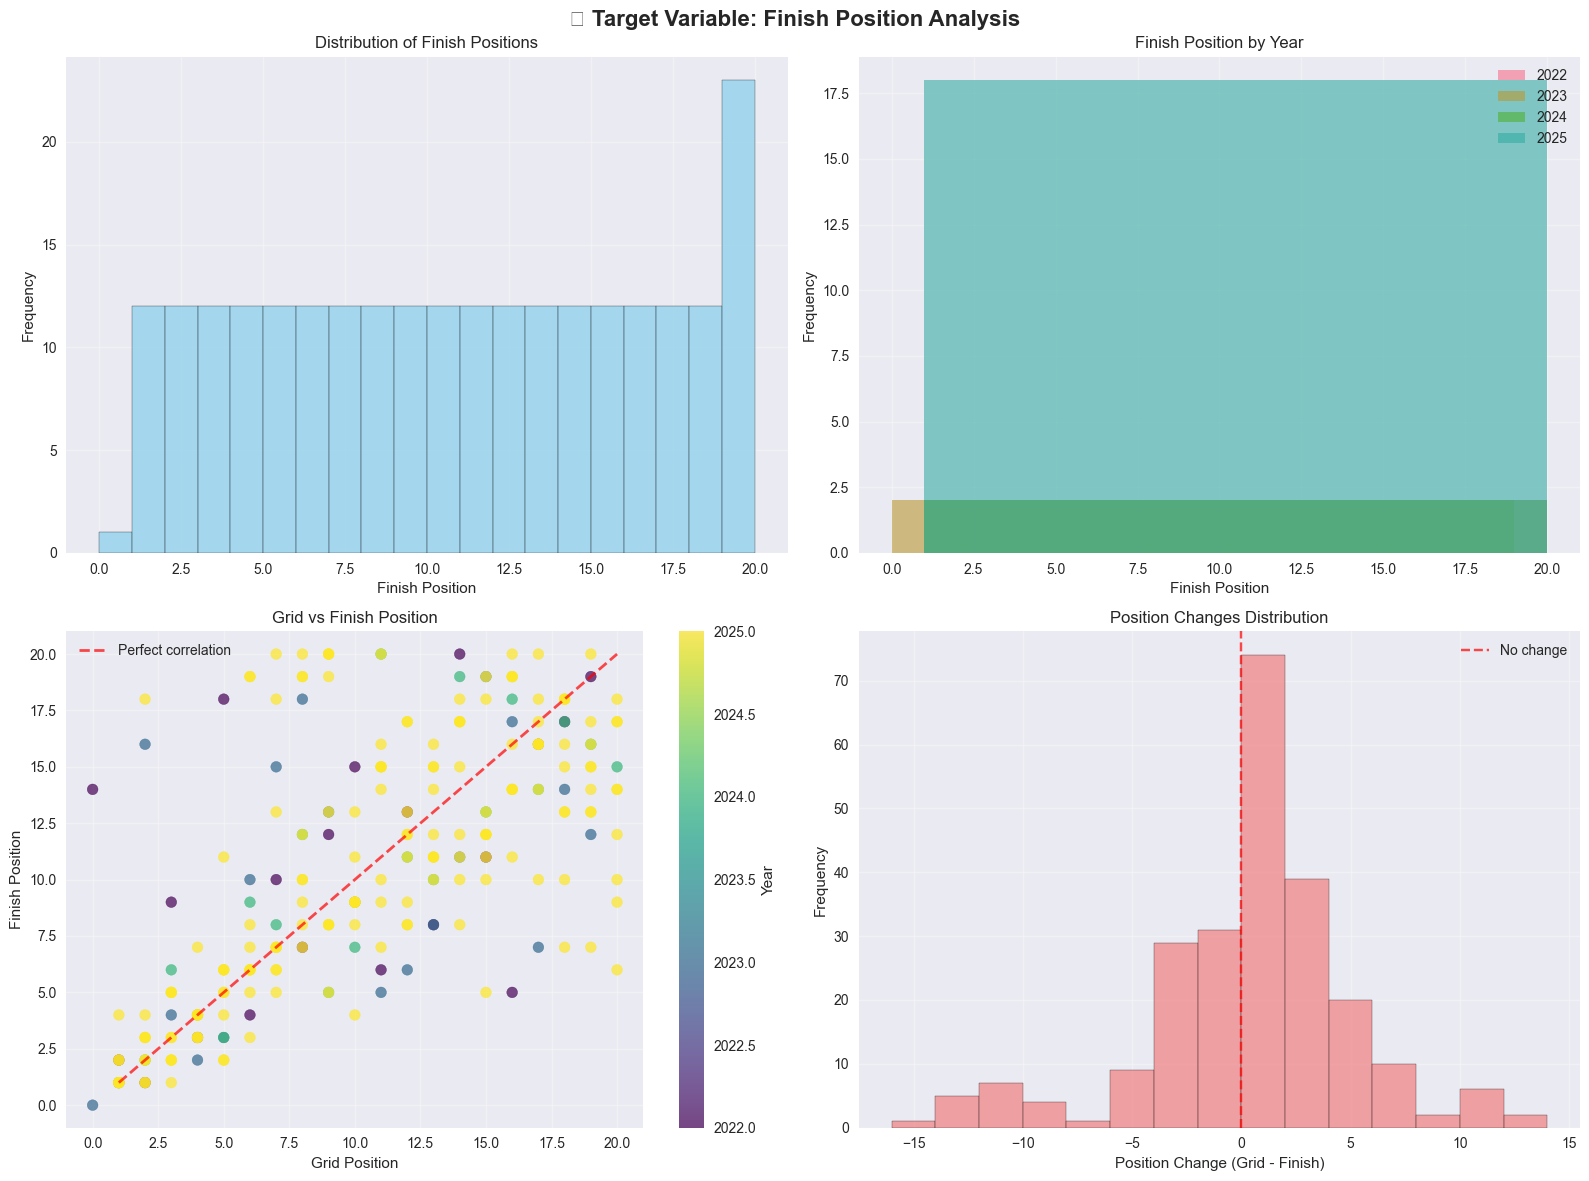


📈 Grid-Finish Correlation: 0.657
📊 Average position change: -0.03 positions
🎯 Biggest mover: Oliver Bearman (+14)
📉 Biggest loser: Lando Norris (-16)


In [5]:
if not df.empty:
    # Finish position distribution
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🎯 Target Variable: Finish Position Analysis', fontsize=16, fontweight='bold')
    
    # 1. Finish position distribution
    axes[0,0].hist(df['finish_pos'], bins=20, alpha=0.7, edgecolor='black', color='skyblue')
    axes[0,0].set_xlabel('Finish Position')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Distribution of Finish Positions')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Finish position by year
    for year in sorted(df['year'].unique()):
        year_data = df[df['year'] == year]['finish_pos']
        axes[0,1].hist(year_data, alpha=0.6, label=str(year), bins=10)
    axes[0,1].set_xlabel('Finish Position')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Finish Position by Year')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Grid vs Finish correlation
    scatter = axes[1,0].scatter(df['grid_pos'], df['finish_pos'], 
                               c=df['year'], cmap='viridis', alpha=0.7, s=60)
    axes[1,0].plot([1, 20], [1, 20], 'r--', alpha=0.7, linewidth=2, label='Perfect correlation')
    axes[1,0].set_xlabel('Grid Position')
    axes[1,0].set_ylabel('Finish Position')
    axes[1,0].set_title('Grid vs Finish Position')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1,0], label='Year')
    
    # 4. Position changes histogram
    axes[1,1].hist(df['pos_change'], bins=15, alpha=0.7, edgecolor='black', color='lightcoral')
    axes[1,1].axvline(0, color='red', linestyle='--', alpha=0.7, label='No change')
    axes[1,1].set_xlabel('Position Change (Grid - Finish)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Position Changes Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Correlation analysis
    print(f"\n📈 Grid-Finish Correlation: {df[['grid_pos', 'finish_pos']].corr().iloc[0,1]:.3f}")
    print(f"📊 Average position change: {df['pos_change'].mean():.2f} positions")
    print(f"🎯 Biggest mover: {df.loc[df['pos_change'].idxmax(), 'driver_name']} (+{df['pos_change'].max():.0f})")
    print(f"📉 Biggest loser: {df.loc[df['pos_change'].idxmin(), 'driver_name']} ({df['pos_change'].min():.0f})")

## 🏎️ Driver Performance Analysis

🏎️ TOP PERFORMERS (by total points):
                 Total_Points  Avg_Finish  Avg_Grid  Avg_Change  Races
driver_name                                                           
Lando Norris            187.0        4.25      4.08       -0.17     12
Oscar Piastri           172.0        5.55      4.91       -0.64     11
Max Verstappen          154.0        5.08      4.75       -0.33     12
Charles Leclerc         131.0        5.58      4.42       -1.17     12
George Russell          123.0        6.08      4.67       -0.25     12
Carlos Sainz             81.0        9.92      8.50       -1.42     12
Lewis Hamilton           78.0        7.83      8.25        0.42     12
Liam Lawson              42.0        8.90      8.60       -0.30     10
Kimi Antonelli           33.0       11.56      9.67       -1.89      9
Sergio Perez             30.0        6.33      9.33        3.00      3


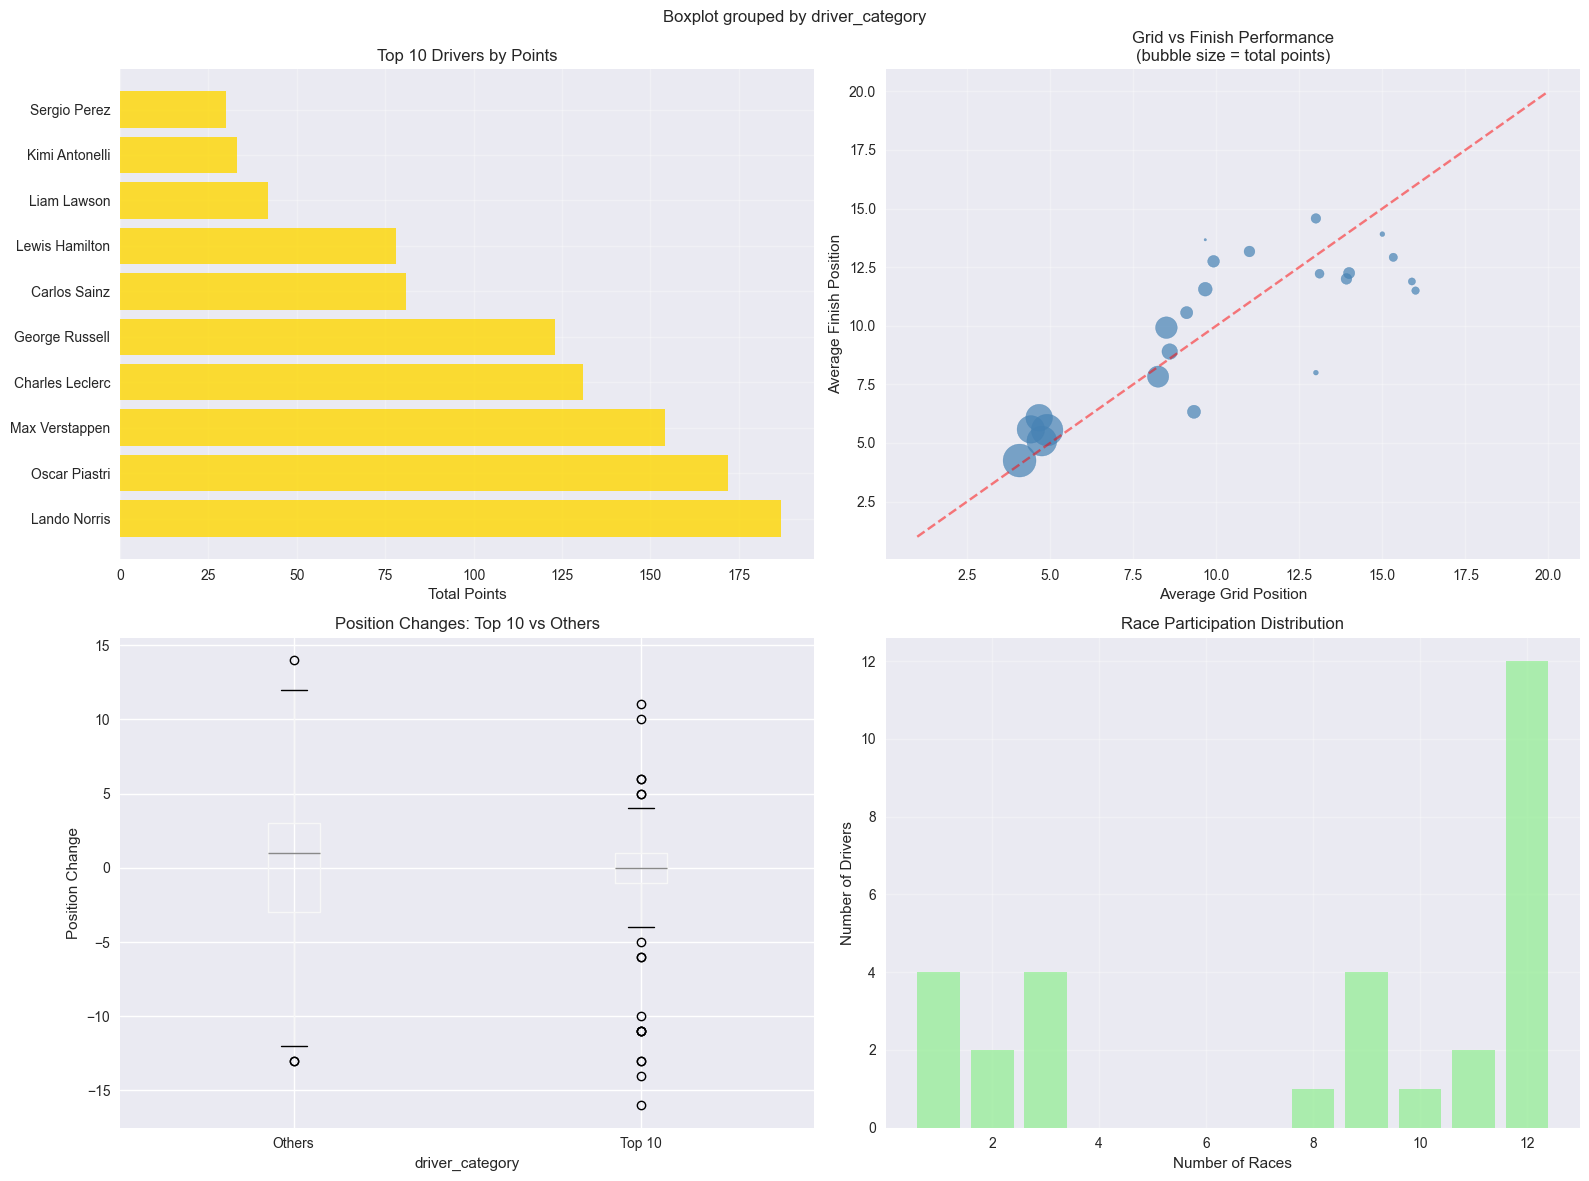

In [6]:
if not df.empty:
    # Driver performance metrics
    driver_stats = df.groupby('driver_name').agg({
        'points': 'sum',
        'finish_pos': 'mean',
        'grid_pos': 'mean',
        'pos_change': 'mean',
        'year': 'count'
    }).round(2)
    driver_stats.columns = ['Total_Points', 'Avg_Finish', 'Avg_Grid', 'Avg_Change', 'Races']
    driver_stats = driver_stats.sort_values('Total_Points', ascending=False)
    
    print("🏎️ TOP PERFORMERS (by total points):")
    print(driver_stats.head(10))
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🏎️ Driver Performance Analysis', fontsize=16, fontweight='bold')
    
    # Top 10 drivers by points
    top10 = driver_stats.head(10)
    axes[0,0].barh(range(len(top10)), top10['Total_Points'], color='gold', alpha=0.8)
    axes[0,0].set_yticks(range(len(top10)))
    axes[0,0].set_yticklabels(top10.index, fontsize=10)
    axes[0,0].set_xlabel('Total Points')
    axes[0,0].set_title('Top 10 Drivers by Points')
    axes[0,0].grid(True, alpha=0.3)
    
    # Average finish vs grid position
    axes[0,1].scatter(driver_stats['Avg_Grid'], driver_stats['Avg_Finish'], 
                     s=driver_stats['Total_Points']*3, alpha=0.7, color='steelblue')
    axes[0,1].plot([1, 20], [1, 20], 'r--', alpha=0.5)
    axes[0,1].set_xlabel('Average Grid Position')
    axes[0,1].set_ylabel('Average Finish Position')
    axes[0,1].set_title('Grid vs Finish Performance\n(bubble size = total points)')
    axes[0,1].grid(True, alpha=0.3)
    
    # Position change distribution by driver category
    top_drivers = driver_stats.head(10).index
    df['driver_category'] = df['driver_name'].apply(lambda x: 'Top 10' if x in top_drivers else 'Others')
    
    df.boxplot(column='pos_change', by='driver_category', ax=axes[1,0])
    axes[1,0].set_title('Position Changes: Top 10 vs Others')
    axes[1,0].set_ylabel('Position Change')
    
    # Race participation
    participation = driver_stats['Races'].value_counts().sort_index()
    axes[1,1].bar(participation.index, participation.values, alpha=0.7, color='lightgreen')
    axes[1,1].set_xlabel('Number of Races')
    axes[1,1].set_ylabel('Number of Drivers')
    axes[1,1].set_title('Race Participation Distribution')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## ⏱️ Qualifying Performance Analysis

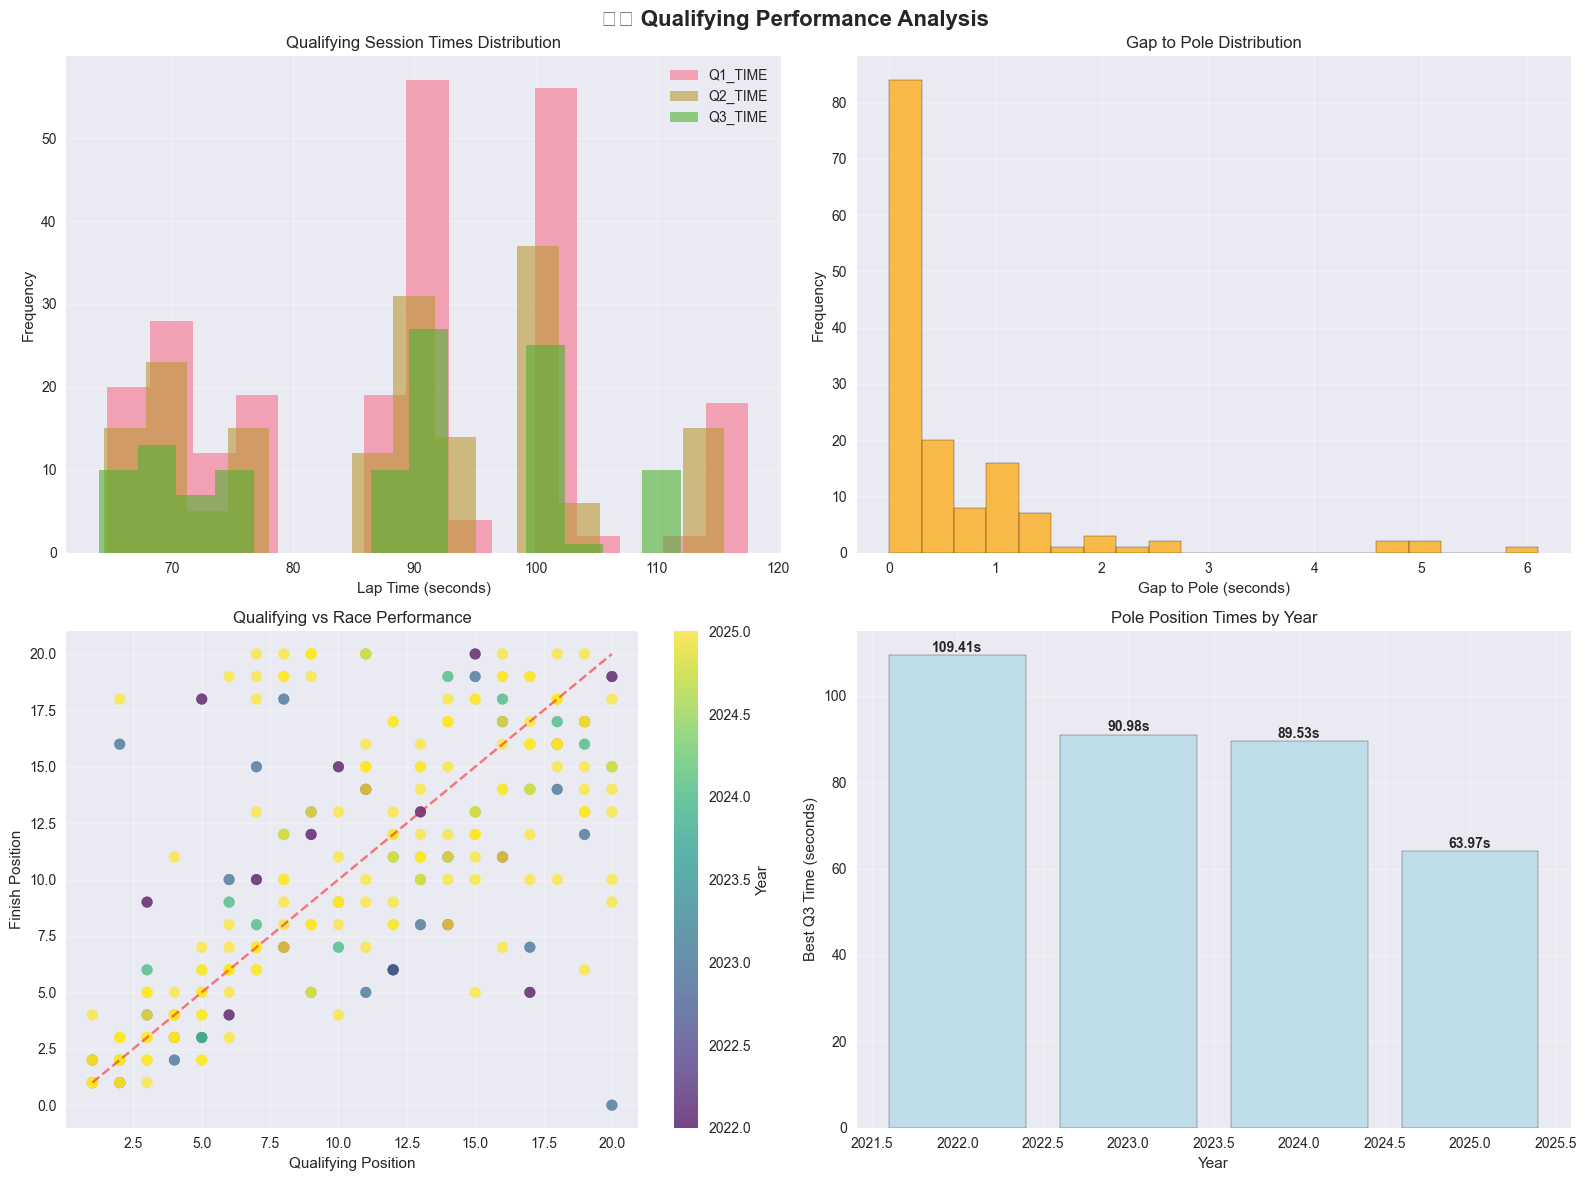


⏱️ QUALIFYING STATISTICS:
Average gap to pole: 0.578 seconds
Largest gap to pole: 6.106 seconds
Fastest pole time: 63.971s (2025)
Qualifying-Race correlation: 0.651


In [7]:
if not df.empty:
    # Filter out zero/invalid times
    quali_df = df[(df['q1_time'] > 0) | (df['q2_time'] > 0) | (df['q3_time'] > 0)]
    
    if not quali_df.empty:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('⏱️ Qualifying Performance Analysis', fontsize=16, fontweight='bold')
        
        # Q1, Q2, Q3 time distributions
        for i, session in enumerate(['q1_time', 'q2_time', 'q3_time']):
            session_data = quali_df[quali_df[session] > 0][session]
            if not session_data.empty:
                axes[0,0].hist(session_data, alpha=0.6, label=session.upper(), bins=15)
        axes[0,0].set_xlabel('Lap Time (seconds)')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].set_title('Qualifying Session Times Distribution')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Gap to pole analysis
        gap_data = quali_df[quali_df['gap_to_pole'] >= 0]['gap_to_pole']
        if not gap_data.empty:
            axes[0,1].hist(gap_data, bins=20, alpha=0.7, color='orange', edgecolor='black')
            axes[0,1].set_xlabel('Gap to Pole (seconds)')
            axes[0,1].set_ylabel('Frequency')
            axes[0,1].set_title('Gap to Pole Distribution')
            axes[0,1].grid(True, alpha=0.3)
        
        # Qualifying vs race performance
        valid_quali = quali_df[quali_df['quali_pos'] > 0]
        if not valid_quali.empty:
            scatter = axes[1,0].scatter(valid_quali['quali_pos'], valid_quali['finish_pos'],
                                       c=valid_quali['year'], cmap='viridis', alpha=0.7, s=60)
            axes[1,0].plot([1, 20], [1, 20], 'r--', alpha=0.5)
            axes[1,0].set_xlabel('Qualifying Position')
            axes[1,0].set_ylabel('Finish Position')
            axes[1,0].set_title('Qualifying vs Race Performance')
            axes[1,0].grid(True, alpha=0.3)
            plt.colorbar(scatter, ax=axes[1,0], label='Year')
        
        # Best qualifying times by year
        yearly_best = []
        for year in sorted(quali_df['year'].unique()):
            year_data = quali_df[quali_df['year'] == year]
            best_q3 = year_data[year_data['q3_time'] > 0]['q3_time'].min()
            if not pd.isna(best_q3):
                yearly_best.append((year, best_q3))
        
        if yearly_best:
            years, times = zip(*yearly_best)
            axes[1,1].bar(years, times, alpha=0.7, color='lightblue', edgecolor='black')
            axes[1,1].set_xlabel('Year')
            axes[1,1].set_ylabel('Best Q3 Time (seconds)')
            axes[1,1].set_title('Pole Position Times by Year')
            axes[1,1].grid(True, alpha=0.3)
            
            # Add values on bars
            for i, (year, time) in enumerate(yearly_best):
                axes[1,1].text(year, time + 0.1, f'{time:.2f}s', 
                              ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Qualifying statistics
        print("\n⏱️ QUALIFYING STATISTICS:")
        if not gap_data.empty:
            print(f"Average gap to pole: {gap_data.mean():.3f} seconds")
            print(f"Largest gap to pole: {gap_data.max():.3f} seconds")
        
        if yearly_best:
            fastest_year, fastest_time = min(yearly_best, key=lambda x: x[1])
            print(f"Fastest pole time: {fastest_time:.3f}s ({fastest_year})")
            
        if not valid_quali.empty:
            quali_race_corr = valid_quali[['quali_pos', 'finish_pos']].corr().iloc[0,1]
            print(f"Qualifying-Race correlation: {quali_race_corr:.3f}")

## 🔧 Strategy Analysis (Pit Stops & Tyres)

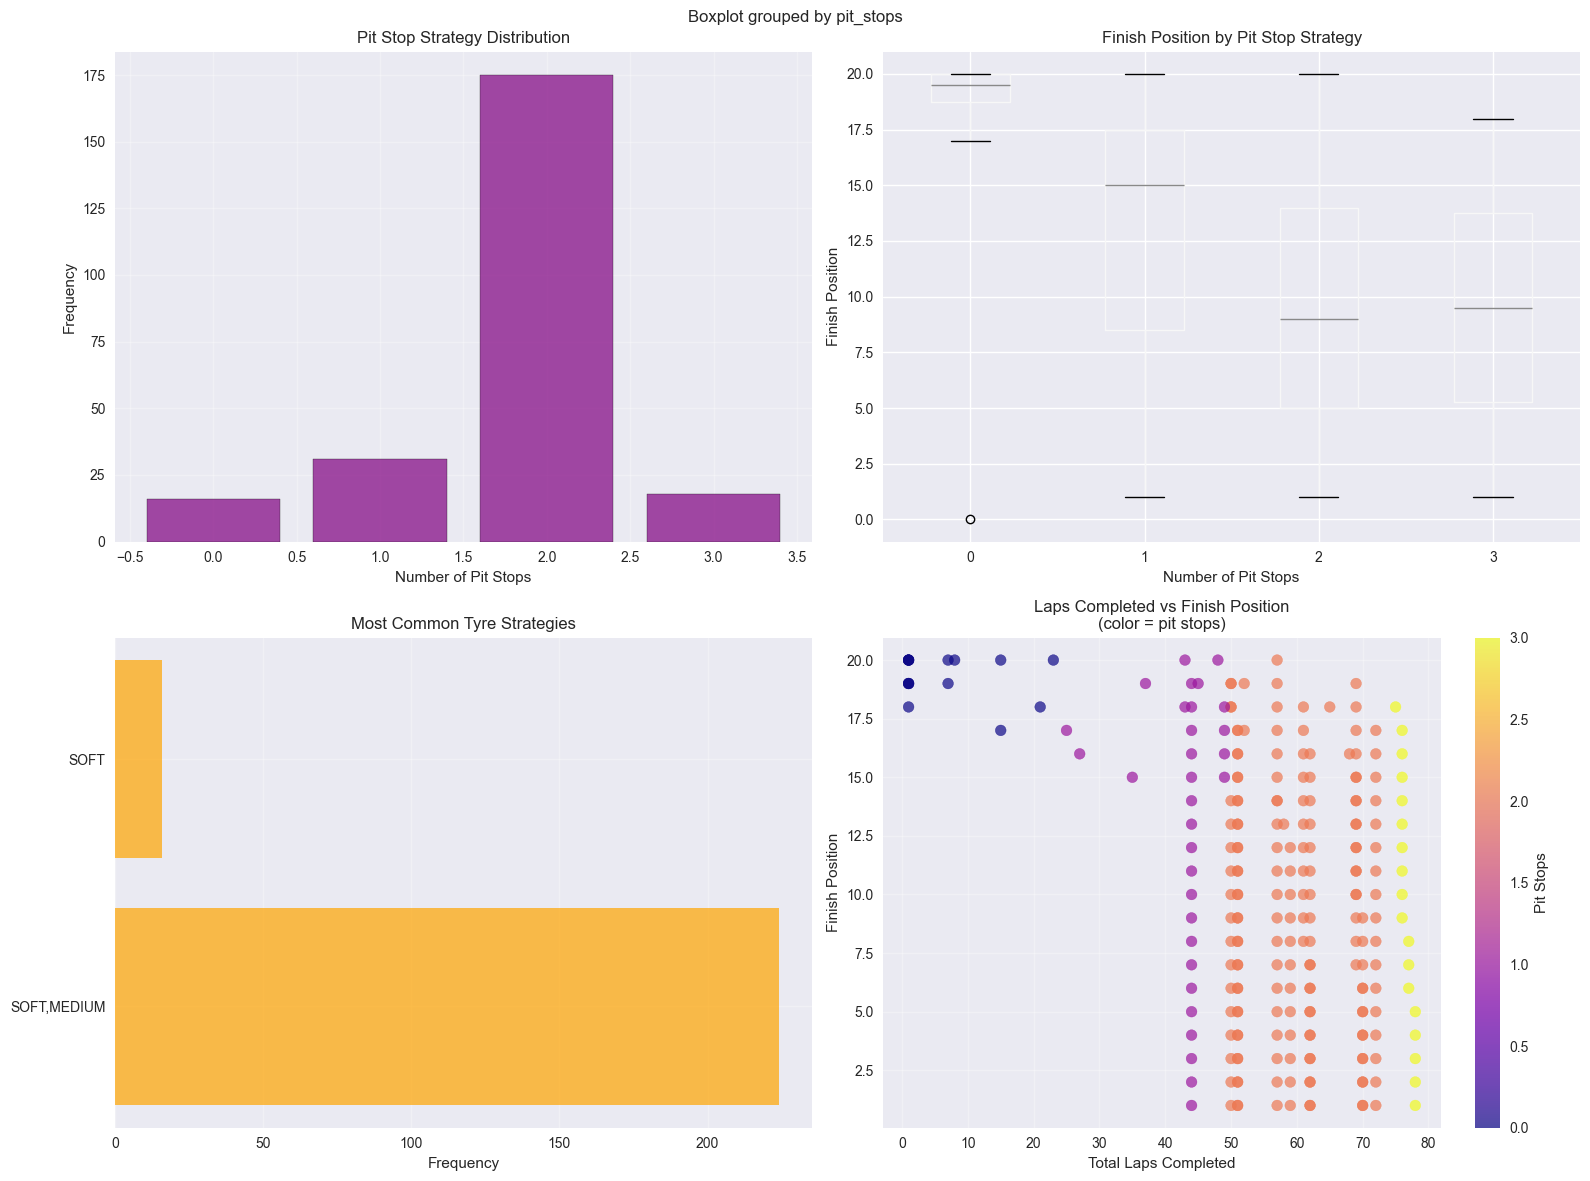


🔧 STRATEGY INSIGHTS:
Most common pit stop count: 2
Average pit stops: 1.81

📊 Performance by pit stop strategy:
           Avg_Finish  Count  Avg_Points
pit_stops                               
0               18.06     16        0.00
1               12.90     31        3.26
2                9.37    175        5.78
3                9.50     18        5.61


In [8]:
if not df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🔧 Race Strategy Analysis', fontsize=16, fontweight='bold')
    
    # Pit stops distribution
    pit_stop_counts = df['pit_stops'].value_counts().sort_index()
    axes[0,0].bar(pit_stop_counts.index, pit_stop_counts.values, 
                  alpha=0.7, color='purple', edgecolor='black')
    axes[0,0].set_xlabel('Number of Pit Stops')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Pit Stop Strategy Distribution')
    axes[0,0].grid(True, alpha=0.3)
    
    # Pit stops vs finish position
    df.boxplot(column='finish_pos', by='pit_stops', ax=axes[0,1])
    axes[0,1].set_xlabel('Number of Pit Stops')
    axes[0,1].set_ylabel('Finish Position')
    axes[0,1].set_title('Finish Position by Pit Stop Strategy')
    
    # Tyre compound usage
    tyre_usage = df['tyres_used'].value_counts().head(10)
    axes[1,0].barh(range(len(tyre_usage)), tyre_usage.values, 
                   alpha=0.7, color='orange')
    axes[1,0].set_yticks(range(len(tyre_usage)))
    axes[1,0].set_yticklabels(tyre_usage.index, fontsize=10)
    axes[1,0].set_xlabel('Frequency')
    axes[1,0].set_title('Most Common Tyre Strategies')
    axes[1,0].grid(True, alpha=0.3)
    
    # Total laps vs finish position
    valid_laps = df[df['total_laps'] > 0]
    if not valid_laps.empty:
        scatter = axes[1,1].scatter(valid_laps['total_laps'], valid_laps['finish_pos'],
                                   c=valid_laps['pit_stops'], cmap='plasma', 
                                   alpha=0.7, s=60)
        axes[1,1].set_xlabel('Total Laps Completed')
        axes[1,1].set_ylabel('Finish Position')
        axes[1,1].set_title('Laps Completed vs Finish Position\n(color = pit stops)')
        axes[1,1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[1,1], label='Pit Stops')
    
    plt.tight_layout()
    plt.show()
    
    # Strategy insights
    print("\n🔧 STRATEGY INSIGHTS:")
    print(f"Most common pit stop count: {df['pit_stops'].mode().iloc[0]:.0f}")
    print(f"Average pit stops: {df['pit_stops'].mean():.2f}")
    
    # Analyze strategy effectiveness
    strategy_performance = df.groupby('pit_stops').agg({
        'finish_pos': ['mean', 'count'],
        'points': 'mean'
    }).round(2)
    strategy_performance.columns = ['Avg_Finish', 'Count', 'Avg_Points']
    print("\n📊 Performance by pit stop strategy:")
    print(strategy_performance)

## 📈 Feature Correlations

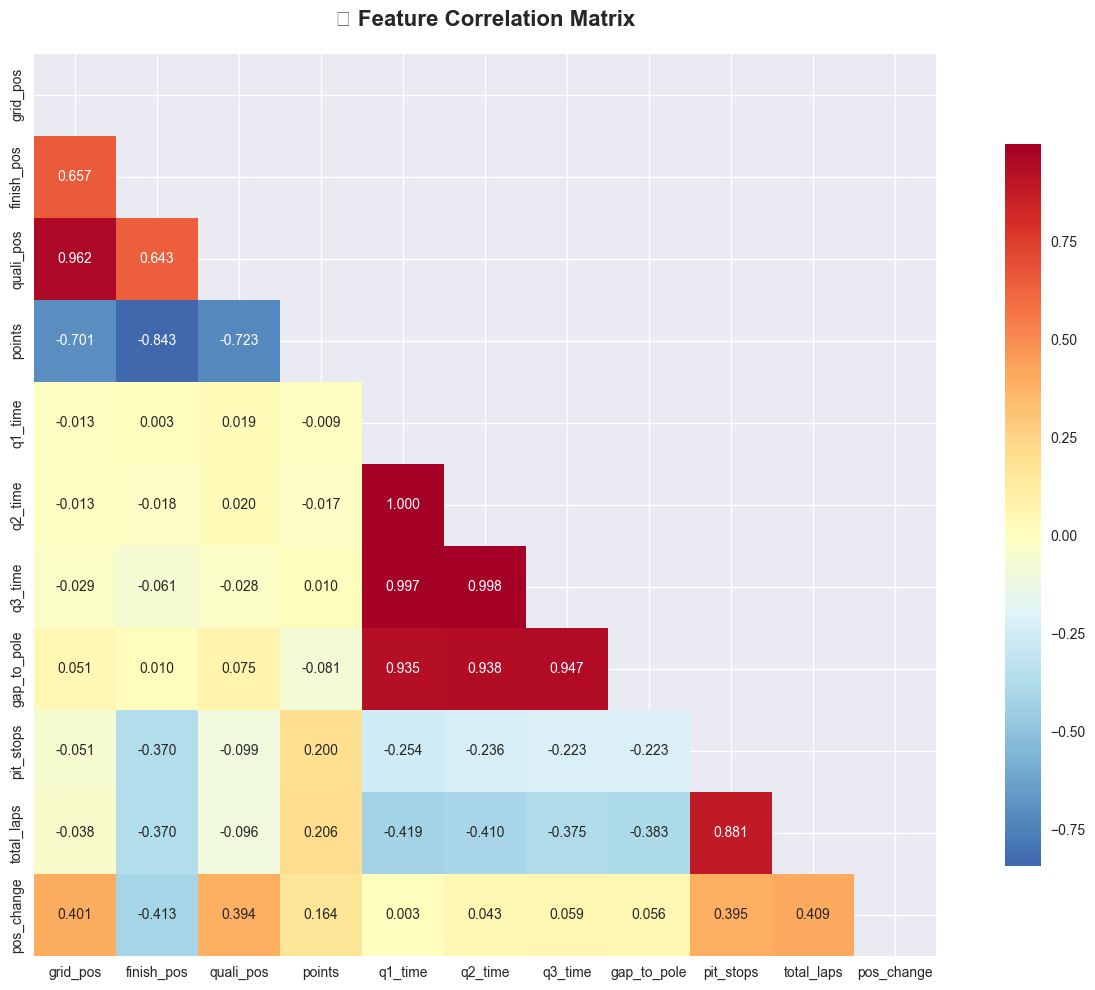


📊 STRONGEST CORRELATIONS WITH FINISH POSITION:
points          | 0.843 | 📉 Negative
grid_pos        | 0.657 | 📈 Positive
quali_pos       | 0.643 | 📈 Positive
pos_change      | 0.413 | 📉 Negative
total_laps      | 0.370 | 📉 Negative
pit_stops       | 0.370 | 📉 Negative
q3_time         | 0.061 | 📉 Negative
q2_time         | 0.018 | 📉 Negative

🎯 KEY INSIGHTS FOR MODELING:
• Grid position is moderately predictive
• Qualifying position correlation: 0.643
• Pit stop strategy impact: High
• Position volatility: 4.71 positions (std dev)


In [9]:
if not df.empty:
    # Select numeric features for correlation analysis
    numeric_features = [
        'grid_pos', 'finish_pos', 'quali_pos', 'points',
        'q1_time', 'q2_time', 'q3_time', 'gap_to_pole',
        'pit_stops', 'total_laps', 'pos_change'
    ]
    
    # Filter available columns
    available_features = [col for col in numeric_features if col in df.columns]
    correlation_df = df[available_features]
    
    # Replace zeros with NaN for certain features to get better correlations
    time_features = ['q1_time', 'q2_time', 'q3_time', 'gap_to_pole']
    for feature in time_features:
        if feature in correlation_df.columns:
            correlation_df.loc[correlation_df[feature] == 0, feature] = np.nan
    
    # Calculate correlation matrix
    corr_matrix = correlation_df.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(14, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r', 
                center=0, square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
    plt.title('📈 Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Most important correlations with finish position
    finish_pos_corr = corr_matrix['finish_pos'].abs().sort_values(ascending=False)
    finish_pos_corr = finish_pos_corr.drop('finish_pos')  # Remove self-correlation
    
    print("\n📊 STRONGEST CORRELATIONS WITH FINISH POSITION:")
    for feature, correlation in finish_pos_corr.head(8).items():
        direction = "📈 Positive" if corr_matrix.loc[feature, 'finish_pos'] > 0 else "📉 Negative"
        print(f"{feature:15} | {correlation:.3f} | {direction}")
    
    # Feature importance for modeling
    print("\n🎯 KEY INSIGHTS FOR MODELING:")
    print(f"• Grid position is {'strongly' if abs(corr_matrix.loc['grid_pos', 'finish_pos']) > 0.7 else 'moderately'} predictive")
    
    if 'quali_pos' in corr_matrix.columns:
        quali_finish_corr = corr_matrix.loc['quali_pos', 'finish_pos']
        print(f"• Qualifying position correlation: {quali_finish_corr:.3f}")
    
    if 'pit_stops' in corr_matrix.columns:
        pitstop_finish_corr = corr_matrix.loc['pit_stops', 'finish_pos']
        print(f"• Pit stop strategy impact: {'High' if abs(pitstop_finish_corr) > 0.3 else 'Moderate'}")
    
    print(f"• Position volatility: {df['pos_change'].std():.2f} positions (std dev)")

## 🔄 Year-over-Year Trends

📅 YEAR-OVER-YEAR TRENDS:
      Avg_Pos_Change  Pos_Change_Volatility  Avg_Pit_Stops  Total_Points  \
year                                                                       
2022            -0.3                  5.027          1.550         101.0   
2023             0.0                  6.026          1.750         102.0   
2024             0.0                  3.494          1.900         101.0   
2025             0.0                  4.668          1.839         909.0   

      Avg_Finish  Avg_Laps  
year                        
2022        10.5     47.25  
2023         9.5     54.40  
2024        10.5     58.85  
2025        10.5     56.25  


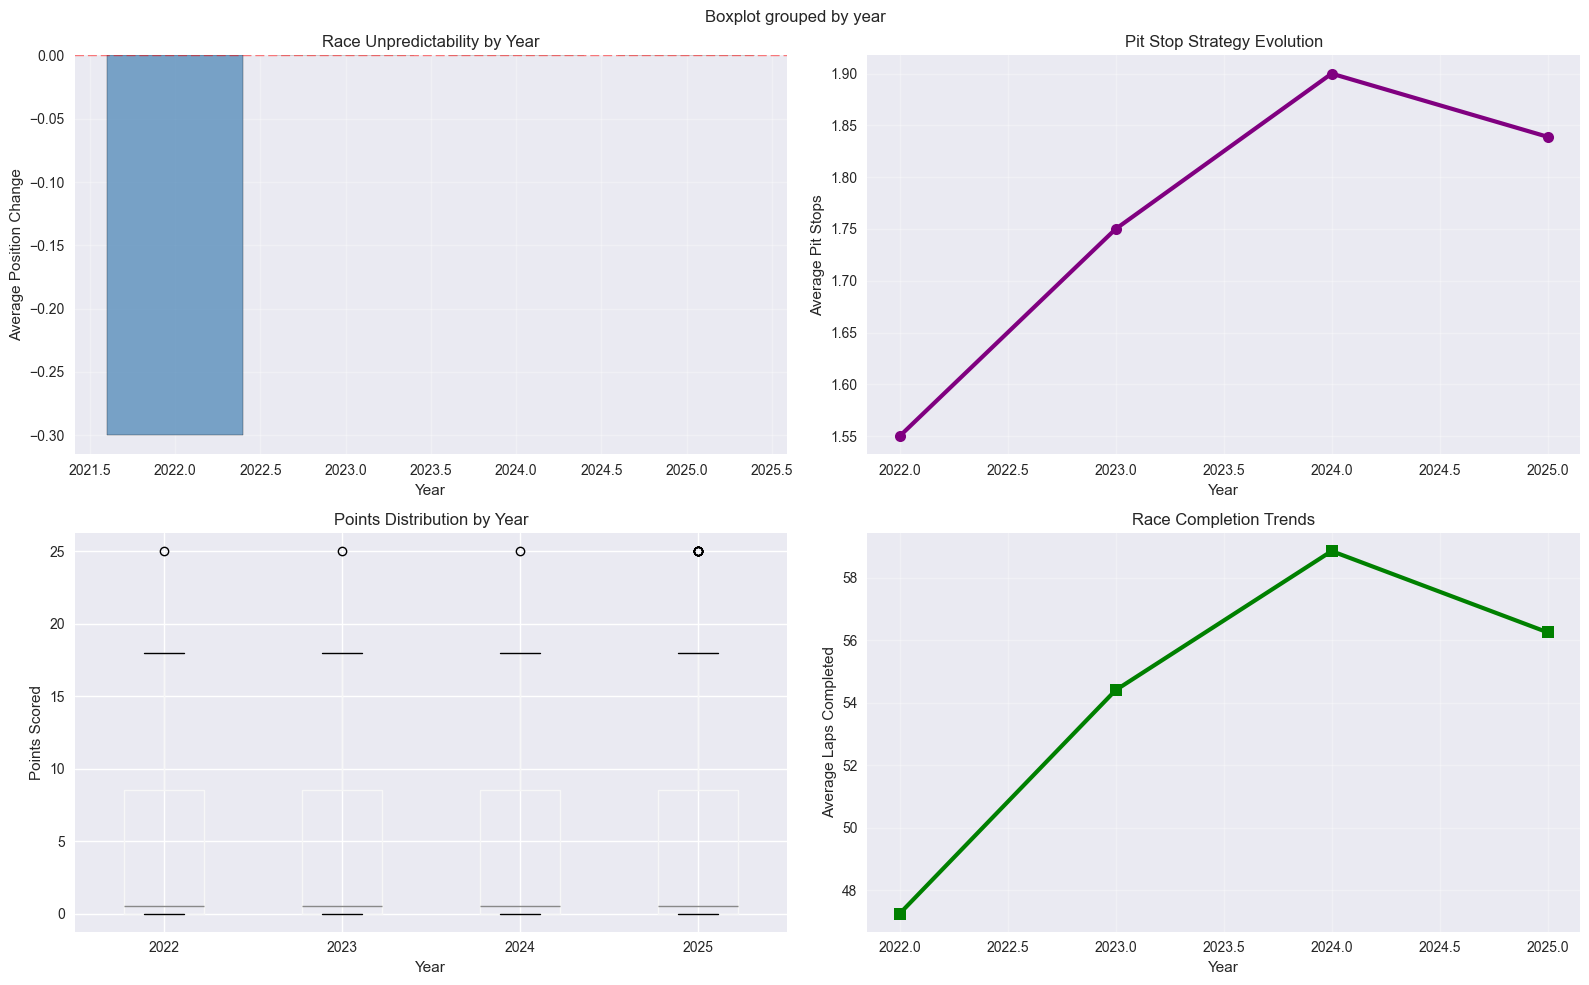


🎲 Most unpredictable year: 2023 (volatility: 6.03)
📊 Most predictable year: 2024 (volatility: 3.49)


In [10]:
if not df.empty and df['year'].nunique() > 1:
    # Determine circuit name from data source or filename
    circuit_name = "Target Circuit"
    if 'data_source' in df.columns:
        # Try to extract circuit name from data source
        sample_source = df['data_source'].iloc[0]
        if 'singapore' in sample_source.lower():
            circuit_name = "Singapore"
        elif 'monaco' in sample_source.lower():
            circuit_name = "Monaco"
        elif 'japan' in sample_source.lower():
            circuit_name = "Japan"
        # Add more circuit detection as needed
    
    # Year-over-year analysis
    yearly_stats = df.groupby('year').agg({
        'pos_change': ['mean', 'std'],
        'pit_stops': 'mean',
        'points': 'sum',
        'finish_pos': 'mean',
        'total_laps': 'mean'
    }).round(3)
    
    yearly_stats.columns = ['Avg_Pos_Change', 'Pos_Change_Volatility', 
                           'Avg_Pit_Stops', 'Total_Points', 'Avg_Finish', 'Avg_Laps']
    
    print("📅 YEAR-OVER-YEAR TRENDS:")
    print(yearly_stats)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'📅 {circuit_name} GP Evolution Over Years', fontsize=16, fontweight='bold')
    
    years = sorted(df['year'].unique())
    
    # Average position changes by year
    axes[0,0].bar(years, yearly_stats['Avg_Pos_Change'], 
                  alpha=0.7, color='steelblue', edgecolor='black')
    axes[0,0].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[0,0].set_xlabel('Year')
    axes[0,0].set_ylabel('Average Position Change')
    axes[0,0].set_title('Race Unpredictability by Year')
    axes[0,0].grid(True, alpha=0.3)
    
    # Pit stop trends
    axes[0,1].plot(years, yearly_stats['Avg_Pit_Stops'], 
                   marker='o', linewidth=3, markersize=8, color='purple')
    axes[0,1].set_xlabel('Year')
    axes[0,1].set_ylabel('Average Pit Stops')
    axes[0,1].set_title('Pit Stop Strategy Evolution')
    axes[0,1].grid(True, alpha=0.3)
    
    # Points distribution by year
    df.boxplot(column='points', by='year', ax=axes[1,0])
    axes[1,0].set_xlabel('Year')
    axes[1,0].set_ylabel('Points Scored')
    axes[1,0].set_title('Points Distribution by Year')
    
    # Race completion trends
    if 'total_laps' in df.columns:
        axes[1,1].plot(years, yearly_stats['Avg_Laps'], 
                       marker='s', linewidth=3, markersize=8, color='green')
        axes[1,1].set_xlabel('Year')
        axes[1,1].set_ylabel('Average Laps Completed')
        axes[1,1].set_title('Race Completion Trends')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Identify most/least predictable years
    most_volatile = yearly_stats['Pos_Change_Volatility'].idxmax()
    least_volatile = yearly_stats['Pos_Change_Volatility'].idxmin()
    
    print(f"\n🎲 Most unpredictable year: {most_volatile} (volatility: {yearly_stats.loc[most_volatile, 'Pos_Change_Volatility']:.2f})")
    print(f"📊 Most predictable year: {least_volatile} (volatility: {yearly_stats.loc[least_volatile, 'Pos_Change_Volatility']:.2f})")

## 📋 Data Quality Assessment

In [11]:
if not df.empty:
    print("📋 DATA QUALITY REPORT")
    print("=" * 50)
    
    # Missing values analysis
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    quality_df = pd.DataFrame({
        'Missing_Count': missing_data,
        'Missing_Percent': missing_percent.round(2),
        'Data_Type': df.dtypes,
        'Unique_Values': df.nunique()
    })
    
    print("\n🔍 Missing Data Analysis:")
    print(quality_df[quality_df['Missing_Count'] > 0])
    
    # Zero values in key features (which might indicate missing data)
    key_features = ['grid_pos', 'finish_pos', 'quali_pos', 'q1_time', 'q2_time', 'q3_time']
    zero_analysis = {}
    
    for feature in key_features:
        if feature in df.columns:
            zero_count = (df[feature] == 0).sum()
            zero_percent = (zero_count / len(df)) * 100
            zero_analysis[feature] = {'count': zero_count, 'percent': zero_percent}
    
    print("\n⚠️ Zero Values Analysis (potential missing data):")
    for feature, stats in zero_analysis.items():
        if stats['count'] > 0:
            print(f"{feature:15} | {stats['count']:3d} zeros ({stats['percent']:5.1f}%)")
    
    # Data consistency checks
    print("\n✅ Data Consistency Checks:")
    
    # Check if grid positions are valid (1-20)
    invalid_grid = df[(df['grid_pos'] < 1) | (df['grid_pos'] > 20)]
    print(f"• Invalid grid positions: {len(invalid_grid)} records")
    
    # Check if finish positions are valid
    invalid_finish = df[(df['finish_pos'] < 1) | (df['finish_pos'] > 20)]
    invalid_finish = invalid_finish[df['status'] != 'DNF']  # Exclude DNFs
    print(f"• Invalid finish positions: {len(invalid_finish)} records")
    
    # Check for duplicate entries
    duplicates = df.duplicated(['year', 'driver_name']).sum()
    print(f"• Duplicate driver entries: {duplicates} records")
    
    # Data completeness score
    core_features = ['year', 'driver_name', 'grid_pos', 'finish_pos', 'points']
    complete_records = df[core_features].notna().all(axis=1).sum()
    completeness = (complete_records / len(df)) * 100
    
    print(f"\n📊 Overall Data Quality Score: {completeness:.1f}% complete")
    
    if completeness >= 90:
        print("🟢 Excellent data quality - ready for modeling")
    elif completeness >= 75:
        print("🟡 Good data quality - minor preprocessing needed")
    else:
        print("🔴 Data quality issues - significant preprocessing required")
    
    # Feature distribution summary for outlier detection
    print("\n📈 Feature Distribution Summary (for outlier detection):")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col in ['grid_pos', 'finish_pos', 'points', 'pit_stops']:
            q1, q3 = df[col].quantile([0.25, 0.75])
            iqr = q3 - q1
            outliers = df[(df[col] < (q1 - 1.5*iqr)) | (df[col] > (q3 + 1.5*iqr))]
            print(f"{col:15} | Outliers: {len(outliers):2d} | Range: {df[col].min():.1f} - {df[col].max():.1f}")

📋 DATA QUALITY REPORT

🔍 Missing Data Analysis:
Empty DataFrame
Columns: [Missing_Count, Missing_Percent, Data_Type, Unique_Values]
Index: []

⚠️ Zero Values Analysis (potential missing data):
grid_pos        |   2 zeros (  0.8%)
finish_pos      |   1 zeros (  0.4%)
q1_time         |   3 zeros (  1.2%)
q2_time         |  67 zeros ( 27.9%)
q3_time         | 127 zeros ( 52.9%)

✅ Data Consistency Checks:
• Invalid grid positions: 2 records
• Invalid finish positions: 1 records
• Duplicate driver entries: 159 records

📊 Overall Data Quality Score: 100.0% complete
🟢 Excellent data quality - ready for modeling

📈 Feature Distribution Summary (for outlier detection):
grid_pos        | Outliers:  0 | Range: 0.0 - 20.0
finish_pos      | Outliers:  0 | Range: 0.0 - 20.0
points          | Outliers: 12 | Range: 0.0 - 25.0
pit_stops       | Outliers: 65 | Range: 0.0 - 3.0


## 🎯 Modeling Recommendations

Based on the analysis above, here are key insights for VAE and Bayesian Network design:

In [12]:
if not df.empty:
    print("🎯 MODELING RECOMMENDATIONS")
    print("=" * 50)
    
    # Feature importance ranking
    if 'finish_pos' in corr_matrix.columns:
        feature_importance = corr_matrix['finish_pos'].abs().sort_values(ascending=False)
        feature_importance = feature_importance.drop('finish_pos')
        
        print("\n🎯 FEATURE PRIORITY FOR MODELS:")
        print("High Priority (>0.5 correlation):")
        high_priority = feature_importance[feature_importance > 0.5]
        for feature, importance in high_priority.items():
            print(f"  • {feature}: {importance:.3f}")
        
        print("\nMedium Priority (0.3-0.5 correlation):")
        medium_priority = feature_importance[(feature_importance > 0.3) & (feature_importance <= 0.5)]
        for feature, importance in medium_priority.items():
            print(f"  • {feature}: {importance:.3f}")
    
    print("\n🧠 VAE ARCHITECTURE SUGGESTIONS:")
    print(f"• Input dimensions: {len(available_features)} features")
    print(f"• Latent dimensions: 3-5 (based on data complexity)")
    print(f"• Training samples: {len(df)} records")
    print("• Encoder: Dense layers with batch normalization")
    print("• Loss: Beta-VAE with β=1.0 (standard) to β=4.0 (disentangled)")
    
    print("\n🕸️ BAYESIAN NETWORK STRUCTURE:")
    print("• Root nodes: year, driver_skill (derived)")
    print("• Intermediate: quali_pos, grid_pos, pit_stops")
    print("• Target: finish_pos (discrete 1-20)")
    print("• Evidence nodes: q3_time, gap_to_pole")
    
    print("\n⚙️ PREPROCESSING PIPELINE:")
    print("1. Handle zero values in qualifying times")
    print("2. Normalize continuous features (StandardScaler)")
    print("3. Encode categorical features (team, driver)")
    print("4. Create derived features (driver_skill, track_experience)")
    print("5. Split by year for temporal validation")
    
    # Dataset size assessment
    total_samples = len(df)
    print(f"\n📊 DATASET SIZE ASSESSMENT:")
    if total_samples < 50:
        print("🔴 Small dataset - use simple models, heavy regularization")
    elif total_samples < 100:
        print("🟡 Medium dataset - moderate complexity models recommended")
    else:
        print("🟢 Sufficient data - can support complex architectures")
    
    print(f"• Total samples: {total_samples}")
    print(f"• Samples per year: {total_samples // df['year'].nunique():.0f}")
    print(f"• Unique drivers: {df['driver_name'].nunique()}")
    
    print("\n🎲 EXPECTED MODELING CHALLENGES:")
    pos_volatility = df['pos_change'].std()
    if pos_volatility > 5:
        print("• High position volatility - expect lower prediction accuracy")
    elif pos_volatility > 3:
        print("• Moderate volatility - good balance of predictability")
    else:
        print("• Low volatility - potentially high prediction accuracy")
    
    print(f"• Position change std dev: {pos_volatility:.2f}")
    print(f"• Grid-finish correlation: {corr_matrix.loc['grid_pos', 'finish_pos']:.3f}")

🎯 MODELING RECOMMENDATIONS

🎯 FEATURE PRIORITY FOR MODELS:
High Priority (>0.5 correlation):
  • points: 0.843
  • grid_pos: 0.657
  • quali_pos: 0.643

Medium Priority (0.3-0.5 correlation):
  • pos_change: 0.413
  • total_laps: 0.370
  • pit_stops: 0.370

🧠 VAE ARCHITECTURE SUGGESTIONS:
• Input dimensions: 11 features
• Latent dimensions: 3-5 (based on data complexity)
• Training samples: 240 records
• Encoder: Dense layers with batch normalization
• Loss: Beta-VAE with β=1.0 (standard) to β=4.0 (disentangled)

🕸️ BAYESIAN NETWORK STRUCTURE:
• Root nodes: year, driver_skill (derived)
• Intermediate: quali_pos, grid_pos, pit_stops
• Target: finish_pos (discrete 1-20)
• Evidence nodes: q3_time, gap_to_pole

⚙️ PREPROCESSING PIPELINE:
1. Handle zero values in qualifying times
2. Normalize continuous features (StandardScaler)
3. Encode categorical features (team, driver)
4. Create derived features (driver_skill, track_experience)
5. Split by year for temporal validation

📊 DATASET SIZE A

## 💾 Save Analysis Results

Export processed data and analysis insights for model development:

In [13]:
if not df.empty:
    # Create analysis summary
    analysis_summary = {
        'dataset_info': {
            'shape': df.shape,
            'years': sorted(df['year'].unique()),
            'drivers': df['driver_name'].nunique(),
            'teams': df['team'].nunique()
        },
        'key_statistics': {
            'avg_position_change': df['pos_change'].mean(),
            'position_volatility': df['pos_change'].std(),
            'grid_finish_correlation': corr_matrix.loc['grid_pos', 'finish_pos'] if 'finish_pos' in corr_matrix.columns else None,
            'avg_pit_stops': df['pit_stops'].mean()
        },
        'data_quality': {
            'completeness_score': completeness,
            'missing_values': missing_data.sum(),
            'zero_values': sum([stats['count'] for stats in zero_analysis.values()])
        }
    }
    
    # Save cleaned dataset for modeling
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Export clean data
    clean_filename = f"data/processed/singapore_cleaned_{timestamp}.csv"
    os.makedirs('data/processed', exist_ok=True)
    df.to_csv(clean_filename, index=False)
    
    # Export correlation matrix
    corr_filename = f"data/processed/correlation_matrix_{timestamp}.csv"
    corr_matrix.to_csv(corr_filename)
    
    print(f"💾 Files saved:")
    print(f"• Clean dataset: {clean_filename}")
    print(f"• Correlation matrix: {corr_filename}")
    
    print(f"\n✅ Analysis complete! Ready for VAE and Bayesian Network implementation.")
    print(f"📊 Dataset: {df.shape[0]} samples × {df.shape[1]} features")
    print(f"🎯 Target: finish_pos (positions 1-20)")
    print(f"📈 Quality score: {completeness:.1f}%")

💾 Files saved:
• Clean dataset: data/processed/singapore_cleaned_20251026_234118.csv
• Correlation matrix: data/processed/correlation_matrix_20251026_234118.csv

✅ Analysis complete! Ready for VAE and Bayesian Network implementation.
📊 Dataset: 240 samples × 21 features
🎯 Target: finish_pos (positions 1-20)
📈 Quality score: 100.0%
